In [1]:
print('hello world')

hello world


In [11]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

/home/s94zalek/shape_matching


In [113]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/shrec16_cuts.yaml')

opt['root_path'] = root_path
opt['dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/shrec16_cuts_archived_20240411_171805


In [90]:
# !python preprocess.py --data_root data/TOPKIDS/ --no_normalize --no_dist --n_eig 200

In [114]:
# data_x = test_set[15]['first']
# data_y = test_set[15]['second']

# get 15th element from test dataloader
for i, data in enumerate(test_loader):
    if i == 5:
        data_x = data['first']
        data_y = data['second']
        break

list(data_x.keys())

['name',
 'verts',
 'faces',
 'evecs',
 'evecs_trans',
 'evals',
 'mass',
 'L',
 'corr']

In [115]:
print('data_x', data_x['name'], 'data_y', data_y['name'])

Pxy = -torch.ones(data_x['verts'].shape[1], dtype=torch.int64)
print('Pxy.shape', Pxy.shape)
Pxy[data_x['corr']] = data_y['corr']

Pyx = -torch.ones(data_y['verts'].shape[1], dtype=torch.int64)
print('Pyx.shape', Pyx.shape)
Pyx[data_y['corr']] = data_x['corr']

# check 
range_1_len = torch.arange(data_x['verts'].shape[1])
print('Pxy', Pxy[:20])
print('Pyx', Pyx[:20])
print(torch.cat((range_1_len.view(-1, 1), Pxy.view(-1, 1)), dim=1)[:20])

data_x ['cat'] data_y ['cuts_cat_shape_14']
Pxy.shape torch.Size([10000])
Pyx.shape torch.Size([2969])
Pxy tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])
Pyx tensor([178, 179, 180, 185, 186, 204, 206, 210, 211, 209, 212, 213, 214, 216,
        217, 218, 219, 220, 221, 248])
tensor([[ 0, -1],
        [ 1, -1],
        [ 2, -1],
        [ 3, -1],
        [ 4, -1],
        [ 5, -1],
        [ 6, -1],
        [ 7, -1],
        [ 8, -1],
        [ 9, -1],
        [10, -1],
        [11, -1],
        [12, -1],
        [13, -1],
        [14, -1],
        [15, -1],
        [16, -1],
        [17, -1],
        [18, -1],
        [19, -1]])


In [116]:
# print number of unique elements in Pxy and count of each element, sorted by count
unique, counts = Pxy.unique(return_counts=True)

# print the values sorted by count
print('unique', unique[torch.argsort(counts, descending=True)])
print('counts', counts[torch.argsort(counts, descending=True)])

unique tensor([  -1, 1779, 1797,  ...,  927,  928,  929])
counts tensor([7605,    1,    1,  ...,    1,    1,    1])


In [117]:
import trimesh

scene = trimesh.Scene()

# Are raw meshes aligned?

In [118]:
import trimesh
import numpy as np

# clear the scene
scene.geometry.clear()

# cmap = trimesh.visual.color.interpolate(np.linspace(0, 1, len(data_y['verts'][0])), 'jet')

# make a color map based on y coordinate
cmap = trimesh.visual.color.interpolate(data_x['verts'][0][:, 0], 'jet')


# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)

mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())
mesh2.visual.vertex_colors = cmap[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

print('distance between vertices in dataset and vertices in mesh object:',
      (data_x['verts'][0].numpy() - mesh1.vertices).sum()
      )

# display the scene
scene.show()

distance between vertices in dataset and vertices in mesh object: 0.0


# After applying correspondences

In [119]:
def index_with_P(tensor_to_index, P):
    # assert tensor_to_index.shape[0] == P.shape[0], f'tensor_to_index.shape {tensor_to_index.shape} != P.shape {P.shape}'
    
    indexed_tensor = tensor_to_index[P]
    
    # replace values where P = -1 with zeros
    if type(indexed_tensor) == torch.Tensor:
        backend = torch 
    elif type(indexed_tensor) == np.ndarray:
        backend = np
    else:
        raise ValueError(f'Unknown type of indexed_tensor {type(indexed_tensor)}')
    
    indexed_tensor[P == -1] = backend.zeros_like(indexed_tensor[P == -1])
    return indexed_tensor
    

# X -> Y


In [120]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

cmap = trimesh.visual.color.interpolate(data_x['verts'][0][:, 1], 'jet')


# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)



mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())

# cmap2 = cmap[Pyx][:len(mesh2.vertices)]
cmap2 = index_with_P(cmap, Pyx)[:len(mesh2.vertices)]
print(cmap2.shape, len(mesh2.vertices))

mesh2.visual.vertex_colors = cmap2
scene.add_geometry(mesh2)

scene.show()

(2969, 4) 2969


# Y -> X

In [121]:
#########################################
# Y -> X
#########################################

scene.geometry.clear()

cmap2 = trimesh.visual.color.interpolate(data_y['verts'][0][:, 1], 'hsv')


# add the second mesh
mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())
mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
cmap = index_with_P(cmap2, Pxy)
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)

scene.show()

# Are eigenfunctions orthogonal?

In [122]:
phi_T_phi = data_x['evecs_trans'][0] @ data_x['evecs'][0]
phi_phi_T = data_x['evecs'][0] @ data_x['evecs_trans'][0]

print('phi.shape', data_x['evecs'][0].shape)
print('phi_T_phi.shape:', phi_T_phi.shape, ', dist(phi_T @ phi, I):', (phi_T_phi - torch.eye(phi_T_phi.shape[0])).abs().sum())
print('phi_phi_T.shape:', phi_phi_T.shape, ', dist(phi @ phi_T, I):', (phi_phi_T - torch.eye(phi_phi_T.shape[0])).abs().sum())

phi.shape torch.Size([10000, 200])
phi_T_phi.shape: torch.Size([200, 200]) , dist(phi_T @ phi, I): tensor(0.0005)
phi_phi_T.shape: torch.Size([10000, 10000]) , dist(phi @ phi_T, I): tensor(53817.2500)


# Calculate the functional map

In [123]:
phi_x = data_x['evecs'][0]
phi_x_T = data_x['evecs_trans'][0]
phi_y = data_y['evecs'][0]
phi_y_T = data_y['evecs_trans'][0]

Cxy = phi_y_T @ index_with_P(phi_x, Pyx)
Cyx = phi_x_T @ index_with_P(phi_y, Pxy)

# print('index_with_P(phi_x, Pyx).shape', index_with_P(phi_x, Pyx).shape)
# print('index_with_P(phi_x, Pyx)', index_with_P(phi_x, Pyx)[:10])

# print('Cxy.shape', Cxy.shape)
# print('Cxy', Cxy[:10])

# print('Cyx.shape', Cyx.shape)
# print('Cyx', Cyx[:10])

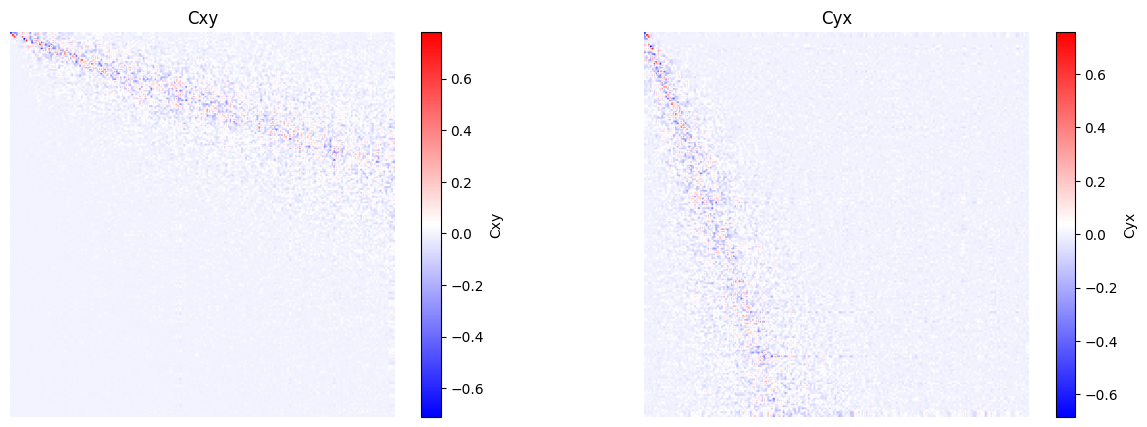

In [124]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Cxy
Cxy_plot = ax[0].imshow(Cxy.cpu().numpy(), cmap='bwr')
ax[0].axis('off')
ax[0].set_title('Cxy')
cbar = plt.colorbar(Cxy_plot)
cbar.set_label('Cxy')

# Cyx
Cyx_plot = ax[1].imshow(Cyx.cpu().numpy(), cmap='bwr')
ax[1].axis('off')
ax[1].set_title('Cyx')
cbar = plt.colorbar(Cyx_plot)
cbar.set_label('Cyx')

plt.show()

# Check for orthogonality

In [125]:
print('dist(Cyx @ Cxy, I)', ((Cyx @ Cxy) - torch.eye(Cxy.shape[0])).abs().sum())
print('dist(Cxy @ Cyx, I)', ((Cxy @ Cyx) - torch.eye(Cxy.shape[0])).abs().sum())
print()

print('dist(Cxy @ Cxy.T, I)', ((Cxy @ Cxy.T) - torch.eye(Cxy.shape[0])).abs().sum())
print('dist(Cyx @ Cyx.T, I)', ((Cyx @ Cyx.T) - torch.eye(Cxy.shape[0])).abs().sum())

dist(Cyx @ Cxy, I) tensor(785.5176)
dist(Cxy @ Cyx, I) tensor(521.7943)

dist(Cxy @ Cxy.T, I) tensor(460.3900)
dist(Cyx @ Cyx.T, I) tensor(825.6698)


# Get the P2P map back

In [126]:
Pyx_after = phi_y @ Cxy @ phi_x_T
Pxy_after = phi_x @ Cyx @ phi_y_T

print('x.shape', data_x['verts'].shape)
print('y.shape', data_y['verts'].shape)
print('Pyx_after.shape', Pyx_after.shape)
print('Pxy_after.shape', Pxy_after.shape)
print('Pyx.shape', Pyx.shape)
print('Pxy.shape', Pxy.shape)

x.shape torch.Size([1, 10000, 3])
y.shape torch.Size([1, 2969, 3])
Pyx_after.shape torch.Size([2969, 10000])
Pxy_after.shape torch.Size([10000, 2969])
Pyx.shape torch.Size([2969])
Pxy.shape torch.Size([10000])


In [127]:
print(Pyx)
print(torch.sum(Pyx_after, dim=1))


tensor([ 178,  179,  180,  ..., 9996, 9997, 9998])
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


In [128]:
#########################################
# X -> Y
#########################################

scene.geometry.clear()

cmap = trimesh.visual.color.interpolate(data_x['verts'][0][:, 1], 'jet')


# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)


mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())

print(cmap.shape)

cmap2 = Pyx_after @ (cmap.astype(np.float32) / 255)
cmap2 = (torch.abs(cmap2).numpy() * 255).astype(np.uint8)


# cmap2 = index_with_P(cmap, Pyx)[:len(mesh2.vertices)]
# print(cmap2.shape, len(mesh2.vertices))

mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

scene.show()

(10000, 4)


In [129]:
#########################################
# Y -> X
#########################################

scene.geometry.clear()

cmap2 = trimesh.visual.color.interpolate(data_y['verts'][0][:, 1], 'hsv')


# add the second mesh
mesh2 = trimesh.Trimesh(vertices=data_y['verts'][0].cpu().numpy() + np.array([1, 0, 0]), faces=data_y['faces'][0].cpu().numpy())
mesh2.visual.vertex_colors = cmap2[:len(mesh2.vertices)]
scene.add_geometry(mesh2)

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x['verts'][0].cpu().numpy(), faces=data_x['faces'][0].cpu().numpy())

cmap = Pxy_after @ (cmap2.astype(np.float32) / 255)
cmap = (torch.abs(cmap).numpy() * 255).astype(np.uint8)

mesh1.visual.vertex_colors = cmap

scene.add_geometry(mesh1)

scene.show()